<a href="https://colab.research.google.com/github/IsraelGebresilasieKimo/aam-micrometeorology/blob/main/Python_Workflow_for_Doppler_Lidar_VAD_Wind_and_Turbulence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab notebook demonstrates how Doppler lidar VAD scans can be processed in Python to retrieve horizontal wind components, estimate vertical velocity, and derive turbulence statistics. The workflow uses xarray and NumPy to handle NetCDF data and is intended for boundary-layer meteorology, urban flow analysis, and CFD inflow validation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


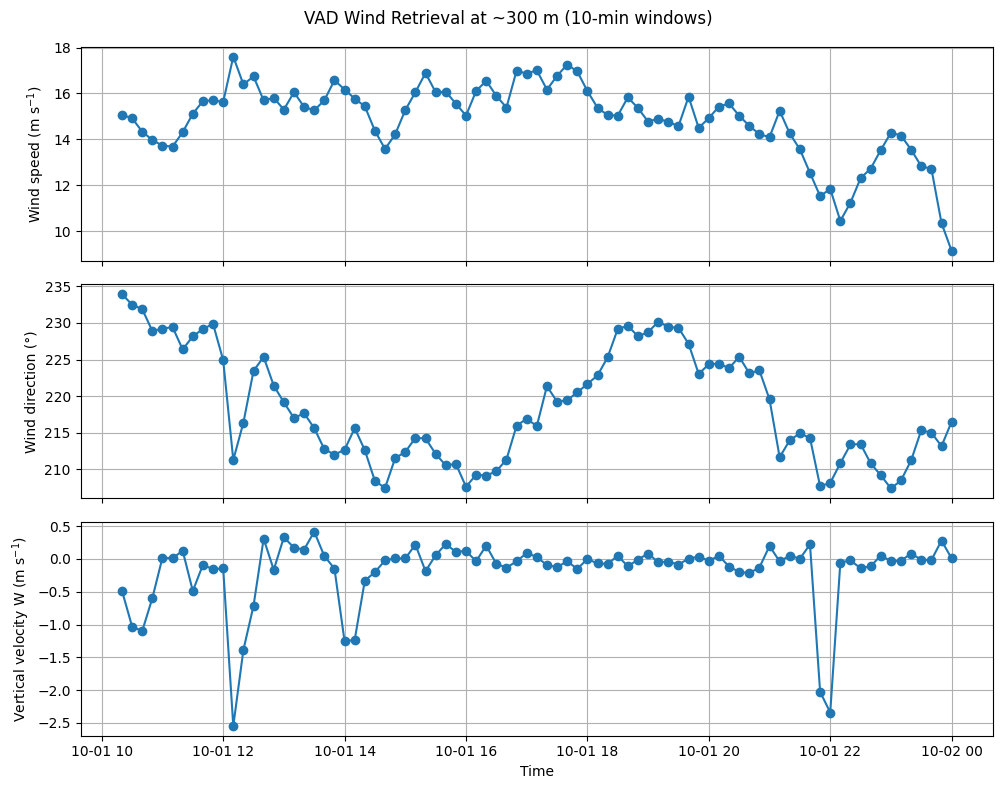

In [ ]:
# =====================================================
# Doppler Lidar VAD Wind Retrieval: U, V, W
# (Correct xarray resample usage)
# =====================================================

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# -----------------------------------------------------
# 1. Load dataset
# -----------------------------------------------------
file_path = "/content/drive/MyDrive/AAM/data.nc"
ds = xr.open_dataset(file_path)

# -----------------------------------------------------
# 2. Extract variables
# -----------------------------------------------------
dv = ds["dv"]
azi = ds["azi"]
zen = ds["zenith"]
qdv = ds["qdv"]

# -----------------------------------------------------
# 3. Select height & apply quality control
# -----------------------------------------------------
height_sel = 300  # meters

dv_h = dv.sel(range=height_sel, method="nearest")
qdv_h = qdv.sel(range=height_sel, method="nearest")
dv_h = dv_h.where(qdv_h == 1)

# -----------------------------------------------------
# 4. VAD retrieval function (U, V, W)
# -----------------------------------------------------
def vad_uv_w(azi_deg, vr, zenith_deg):
    mask = np.isfinite(vr)
    if mask.sum() < 8:
        return np.nan, np.nan, np.nan

    phi = np.deg2rad(azi_deg[mask])
    vr = vr[mask]
    theta = np.deg2rad(np.nanmean(zenith_deg[mask]))

    A = np.column_stack([
        np.cos(phi) * np.cos(theta),
        np.sin(phi) * np.cos(theta)
    ])

    uv, _, _, _ = np.linalg.lstsq(A, vr, rcond=None)
    U, V = uv

    vr_fit = A @ uv
    W = np.nanmean(vr - vr_fit) / np.cos(theta)

    return U, V, W

# -----------------------------------------------------
# 5. Apply VAD over 10-minute windows
# -----------------------------------------------------
U, V, W, t_mid = [], [], [], []

for t, vr_da in dv_h.resample(time="10min"):
    az_da = azi.sel(time=vr_da.time)
    ze_da = zen.sel(time=vr_da.time)

    u, v, w = vad_uv_w(
        az_da.values,
        vr_da.values,
        ze_da.values
    )

    U.append(u)
    V.append(v)
    W.append(w)
    t_mid.append(t)

U = np.array(U)
V = np.array(V)
W = np.array(W)
t_mid = np.array(t_mid)

# -----------------------------------------------------
# 6. Derived quantities
# -----------------------------------------------------
wind_speed = np.sqrt(U**2 + V**2)
wind_dir = (270 - np.rad2deg(np.arctan2(V, U))) % 360

# -----------------------------------------------------
# 7. Plot results
# -----------------------------------------------------
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax[0].plot(t_mid, wind_speed, marker="o")
ax[0].set_ylabel("Wind speed (m s$^{-1}$)")
ax[0].grid(True)

ax[1].plot(t_mid, wind_dir, marker="o")
ax[1].set_ylabel("Wind direction (°)")
ax[1].grid(True)

ax[2].plot(t_mid, W, marker="o")
ax[2].set_ylabel("Vertical velocity W (m s$^{-1}$)")
ax[2].set_xlabel("Time")
ax[2].grid(True)

plt.suptitle("VAD Wind Retrieval at ~300 m (10-min windows)")
plt.tight_layout()
plt.show()


In [ ]:
heights = ds["range"].values

U_prof = []
V_prof = []

# Choose one representative time window (e.g. first valid)
t_ref = t_mid[~np.isnan(U)][0]

# Get time window data
mask_time = ds.time.resample(time="10min").groups[t_ref]

for h in heights:
    dv_h = ds["dv"].sel(range=h, method="nearest").isel(time=mask_time)
    qdv_h = ds["qdv"].sel(range=h, method="nearest").isel(time=mask_time)
    dv_h = dv_h.where(qdv_h == 1)

    u, v, w = vad_uv_w(
        ds["azi"].isel(time=mask_time).values,
        dv_h.values,
        ds["zenith"].isel(time=mask_time).values
    )

    U_prof.append(u)
    V_prof.append(v)

U_prof = np.array(U_prof)
V_prof = np.array(V_prof)


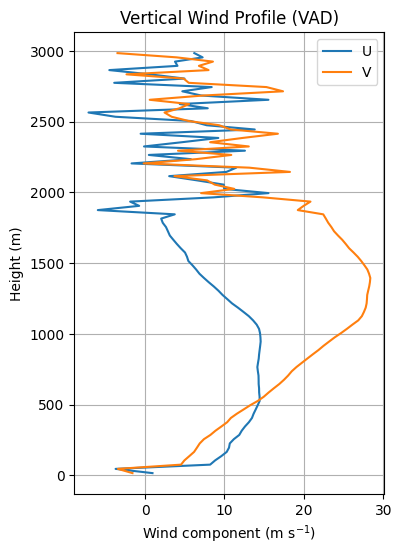

In [ ]:
plt.figure(figsize=(4,6))
plt.plot(U_prof, heights, label="U")
plt.plot(V_prof, heights, label="V")
plt.xlabel("Wind component (m s$^{-1}$)")
plt.ylabel("Height (m)")
plt.title("Vertical Wind Profile (VAD)")
plt.legend()
plt.grid(True)
plt.show()


Turbulence statistics

Wind fluctuations

In [ ]:
u_fluc = U - np.nanmean(U)
v_fluc = V - np.nanmean(V)
w_fluc = W - np.nanmean(W)


Turbulence Intensity (TI)
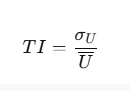

In [ ]:
TI = np.nanstd(wind_speed) / np.nanmean(wind_speed)
print("Turbulence Intensity:", TI)


Turbulence Intensity: 0.109435536


Velocity variances

In [ ]:
sigma_u2 = np.nanvar(u_fluc)
sigma_v2 = np.nanvar(v_fluc)
sigma_w2 = np.nanvar(w_fluc)


Turbulent Kinetic Energy (TKE)    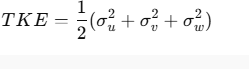

In [ ]:
TKE = 0.5 * (sigma_u2 + sigma_v2 + sigma_w2)
print("TKE (m^2 s^-2):", TKE)


TKE (m^2 s^-2): 3.3405046
